### Pokémodel: Multi-label classification of Pokémon type from pictures

Can I use knowledge of old Pokemon to infer the types of new Pokemon based on their pictures?

Multi-label classification of pokemon type (primary,secondary, and whether its legendary) from a dataset of pictures of every pokemon from generations 1 to 7. Using transfer learning and fine-tuning of ResNet50 using the fastai library. Based on lesson 3 of fastai part 1.

Generations 1-5 were used to train the network, and generations 6-7 were used to test it. The network is extremely prone to overfitting, and can't achieve an F1 score higher than 0.3 on the validation set or the test set. This is due to the small sample size, as the average amount of Pokemon that share the same type combination is only 4.5 while the label-space is $18_{\text{First type}}\times 18_{\text{Second type}}\times 2_{\text{Legendary status}} = 648$. However, the difference between the accuracy achieved on the validation set (89%) versus the test set (8%), shows that there is significant variation in the correlation between image and type between generations.


#### Imports and Data

In [0]:
from fastai.vision import *

In [0]:
!unzip pokemon-images-and-types.zip
!mv images data
!mkdir data/processed
!mkdir data/train
!mkdir data/test

In [0]:
# Convert to png
for i in os.listdir("data/images"):
    img = PIL.Image.open("data/images/"+i)
    img.save("data/processed/"+i[:-3]+"png")
    # img.convert('RGB').save("data/images/"+i[:-3]+"jpg")

In [0]:
legendaries = np.subtract([144,145,146,150,151,243,244,245,249,250,251,377,378,379,380,381,
               382,383,384,385,386,480,481,482,483,484,485,486,487,488,491,638,
               639,640,808,809],1)

df = pd.read_csv('pokemon.csv')
for i in range(df.shape[0]):
    if isinstance(df["Type2"][i], str):
        df["Type1"][i] =df["Type1"][i]+" "+df["Type2"][i]
    if i in legendaries:
        df["Type1"][i]+=" Legendary"
df = df.drop("Type2",axis=1)
dfs = np.split(df,[649])
for name in dfs[0]["Name"]:
    Path("data/processed/"+name+".png").rename("data/train/"+name+".png")
for name in dfs[1]["Name"]:
    Path("data/processed/"+name+".png").rename("data/test/"+name+".png")
dfs[0].head()


In [0]:
np.random.seed(42)
src = (ImageList.from_df(dfs[0],Path(), folder='data/train', suffix='.png')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=" "))

In [0]:
data = (src.transform(tfms,size=120)
        .databunch().normalize(imagenet_stats))

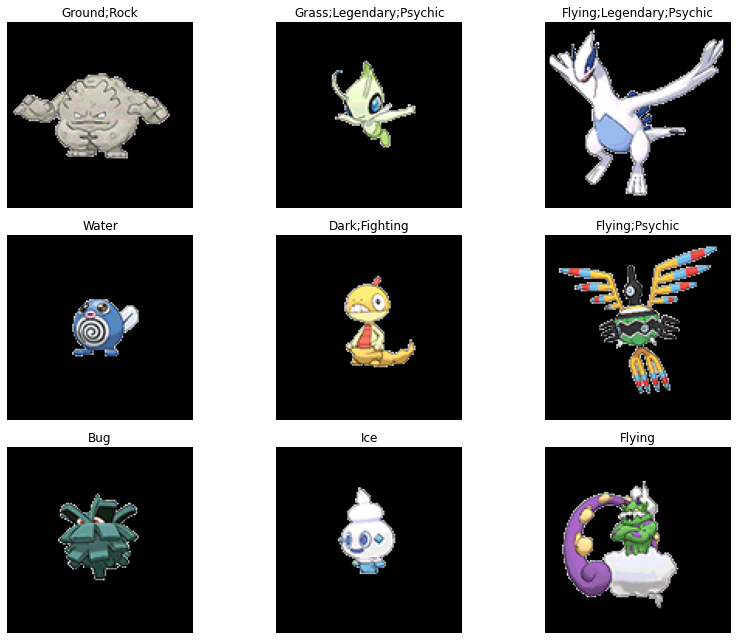

In [0]:
data.show_batch(rows=3, figsize=(12,9))

#### Model Training

In [0]:
arch = models.resnet50
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-02
Min loss divided by 10: 4.37E-02


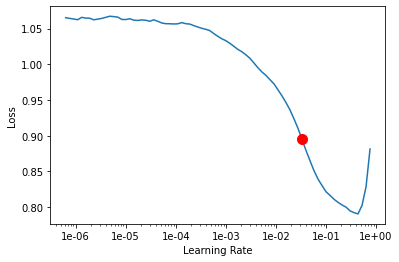

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
learn.fit_one_cycle(5, slice(1e-2))
learn.save('stage-1-rn50')

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,1.042423,1.306427,0.321093,0.311079,00:03
1,0.895190,0.719285,0.368013,0.317325,00:03
2,0.708288,0.313863,0.728682,0.335172,00:03
3,0.560669,0.267863,0.870665,0.288550,00:03
4,0.462907,0.264036,0.882905,0.258277,00:03


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


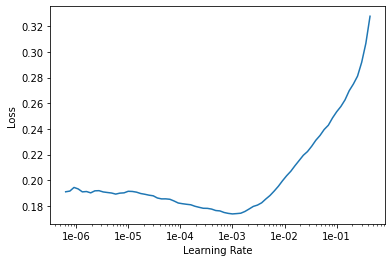

In [0]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, slice(1e-5, 1e-3))
learn.save('stage-2-rn50')

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.190480,0.257563,0.888209,0.269875,00:04
1,0.177960,0.256181,0.902489,0.262212,00:04
2,0.163768,0.252596,0.894737,0.294090,00:04
3,0.148519,0.252037,0.896777,0.315610,00:04
4,0.135692,0.251968,0.893513,0.297229,00:04


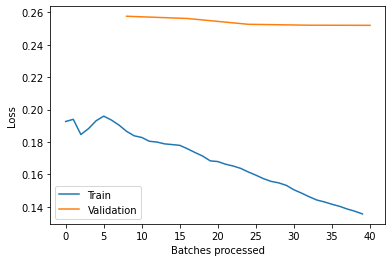

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.export()

#### Examining results: Validation set

In [0]:
print("Accuracy on train set: "+str(learn.validate(data.train_dl)[1].item()))
print("F1 on train set: "+str(learn.validate(data.train_dl)[2].item()))
print("Accuracy on validation set: "+str(learn.validate(data.valid_dl)[1].item()))
print("F1 on validation set: "+str(learn.validate(data.valid_dl)[2].item()))

Accuracy on train set: 0.9845806360244751


F1 on train set: 0.9568332433700562


Accuracy on validation set: 0.8935127854347229


F1 on validation set: 0.29722896218299866


In [0]:
preds,tgts = learn.get_preds(DatasetType.Valid)
filtered = np.where(preds>0.2,1,0)

Truth: ['Bug']
Prediction: ['Normal']


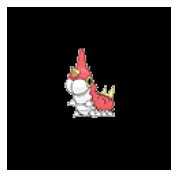

In [0]:
index = np.random.randint(0,len(learn.data.valid_ds))
print("Truth: "+str(np.array(data.classes)[tgts[index]==1]))
print("Prediction: "+str(np.array(data.classes)[filtered[index]==1]))
learn.data.valid_ds[index][0].show()


#### Examining Results: Test set

In [0]:
test = ImageList.from_df(dfs[1],Path(), folder='data/test', suffix='.png')
test_data =(test
            .split_none()
            .label_from_df(label_delim=" ")
            .transform(size=120)
            .databunch()
            .normalize(imagenet_stats))

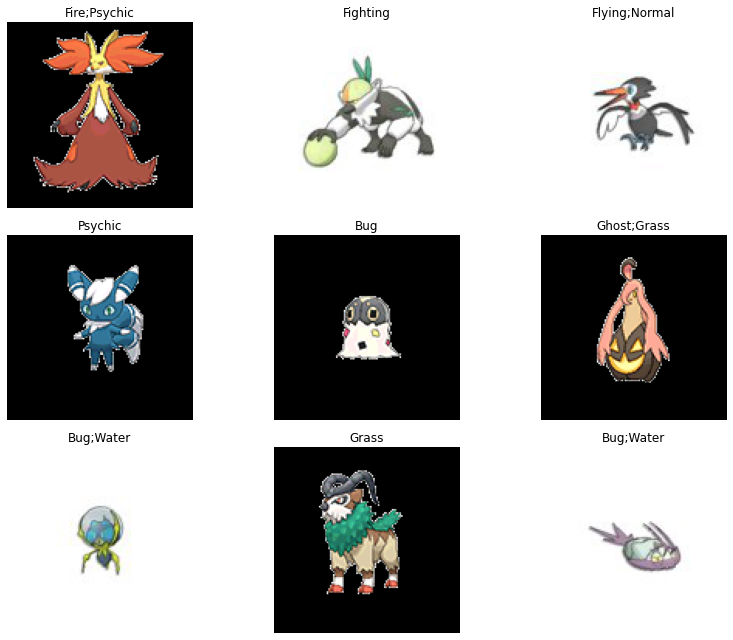

In [0]:
test_data.show_batch(rows=3, figsize=(12,9))

In [0]:
learn = load_learner(Path(),test=test)

In [0]:
preds,tgts = learn.get_preds(DatasetType.Test)
filtered = np.where(preds>0.2,1,0)

In [0]:
labels = np.zeros((160,19))
for rowi, idx_list in enumerate(test_data.label_list.y.items):
    for classidx in idx_list:
        labels[rowi, classidx] = 1

print("Accuracy on test set: "+str(acc_02(preds,torch.from_numpy(labels)).item()))
print("F1 on test set: "+str(f_score(preds,torch.from_numpy(labels)).item()))

Accuracy on test set: 0.084868423640728
F1 on test set: 0.31109100580215454


Name: espurr
Truth: Psychic
Prediction: ['Electric']


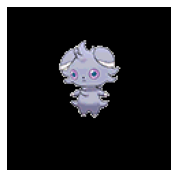

In [0]:
index = np.random.randint(0,len(learn.data.test_ds))
print("Name: "+dfs[1]["Name"][index+649])
print("Truth: "+dfs[1]["Type1"][index+649])
print("Prediction: "+str(np.array(data.classes)[filtered[index]==1]))
learn.data.test_ds[index][0].show()

In [0]:
np.mean(np.unique(df["Type1"],return_counts=True)[1])

4.570621468926554